In [41]:
from IPython.display import Image
%matplotlib inline

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

You should consider upgrading via the 'C:\Users\Shikha\.conda\envs\env_pytorch\python.exe -m pip install --upgrade pip' command.


In [43]:
data_dir = 'input/Class1_def'

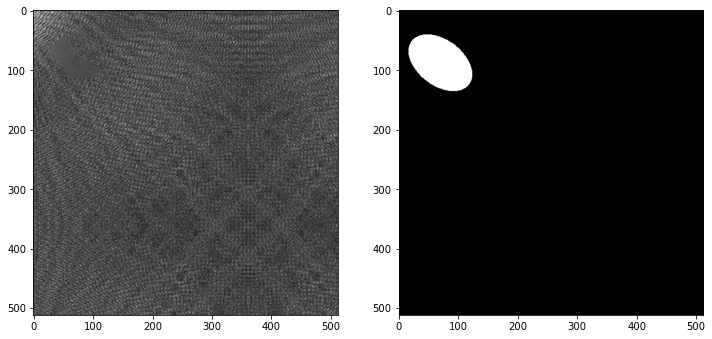

In [44]:
from coslib import plot_ellipse_seg_test

plot_ellipse_seg_test(os.path.join(data_dir, "1.png"))

In [45]:
from coslib import load_images_masks

In [46]:
X, y = load_images_masks(data_dir, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

In [47]:
X.shape

(150, 512, 512, 1)

In [48]:
y.shape

(150, 512, 512, 1)

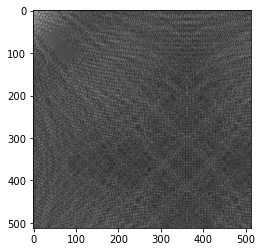

In [49]:
plt.imshow(X[0,:,:,0], cmap='gray')

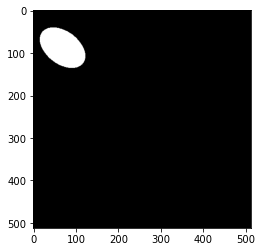

In [50]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [51]:
import sklearn
from sklearn.model_selection import train_test_split

In [52]:
len(X)

150

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [54]:
X_train.shape

(105, 512, 512, 1)

In [55]:
y_train.shape

(105, 512, 512, 1)

In [56]:
X_test.shape

(45, 512, 512, 1)

In [57]:
img_rows = 512
img_cols = 512

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time
from losses import focal_tversky

In [59]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory


def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [60]:
model = get_small_unet()

In [61]:
def recall(y_true, y_pred):
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

In [62]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [63]:
model.compile(optimizer=Adam(lr=1e-4), loss=focal_tversky, metrics=['accuracy', recall, precision])

In [64]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Epoch 1/50
10/10 [==============================] - 173s 17s/step - loss: 0.9186 - accuracy: 0.7607 - recall: 0.2206 - precision: 0.0337 - val_loss: 0.9241 - val_accuracy: 0.5902 - val_recall: 0.5448 - val_precision: 0.0437
Epoch 2/50
10/10 [==============================] - 157s 16s/step - loss: 0.9187 - accuracy: 0.5569 - recall: 0.5937 - precision: 0.0512 - val_loss: 0.9240 - val_accuracy: 0.5126 - val_recall: 0.6305 - val_precision: 0.0429
Epoch 3/50
10/10 [==============================] - 160s 16s/step - loss: 0.9188 - accuracy: 0.4495 - recall: 0.7068 - precision: 0.0474 - val_loss: 0.9240 - val_accuracy: 0.3311 - val_recall: 0.7711 - val_precision: 0.0376
Epoch 4/50
10/10 [==============================] - 158s 16s/step - loss: 0.9185 - accuracy: 0.2667 - recall: 0.8521 - precision: 0.0419 - val_loss: 0.9240 - val_accuracy: 0.2244 - val_recall: 0.8535 - val_precision: 0.0354
Epoch 5/50
10/10 [==============================] - 161s 16s/step - loss: 0.9185 - accuracy: 0.2276 - re

10/10 [==============================] - 143s 14s/step - loss: 0.2480 - accuracy: 0.9835 - recall: 0.9128 - precision: 0.7281 - val_loss: 0.2574 - val_accuracy: 0.9838 - val_recall: 0.9470 - val_precision: 0.7219
Epoch 38/50
10/10 [==============================] - 142s 14s/step - loss: 0.2435 - accuracy: 0.9842 - recall: 0.9038 - precision: 0.7405 - val_loss: 0.2576 - val_accuracy: 0.9835 - val_recall: 0.9490 - val_precision: 0.7162
Epoch 39/50
10/10 [==============================] - 141s 14s/step - loss: 0.2475 - accuracy: 0.9837 - recall: 0.9218 - precision: 0.7192 - val_loss: 0.2574 - val_accuracy: 0.9831 - val_recall: 0.9530 - val_precision: 0.7037
Epoch 40/50
10/10 [==============================] - 142s 14s/step - loss: 0.2502 - accuracy: 0.9845 - recall: 0.9063 - precision: 0.7543 - val_loss: 0.2550 - val_accuracy: 0.9842 - val_recall: 0.9463 - val_precision: 0.7313
Epoch 41/50
10/10 [==============================] - 142s 14s/step - loss: 0.2394 - accuracy: 0.9856 - recall: 0

## Learning curves

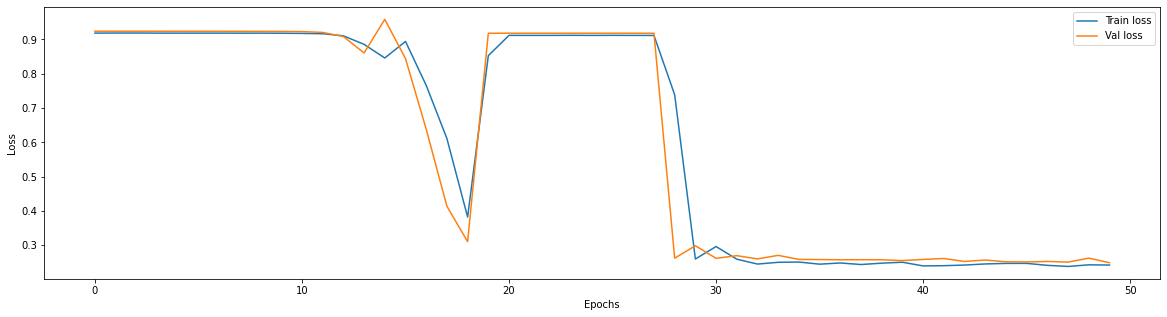

In [65]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

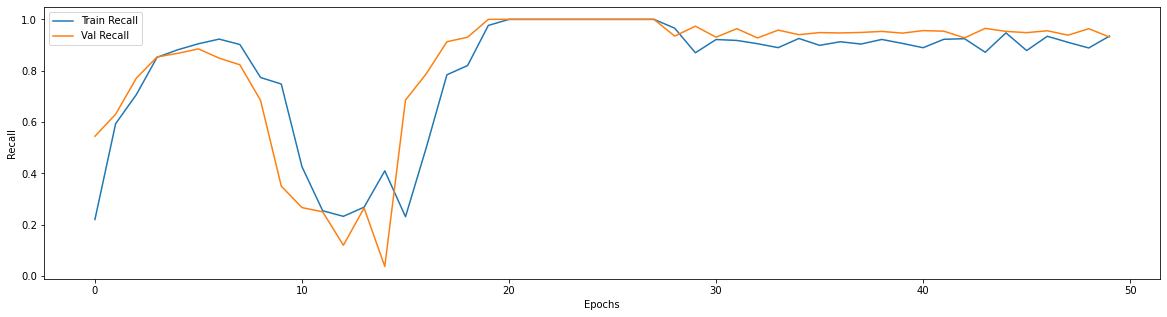

In [66]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['recall'], label='Train Recall')
plt.plot(model.history.history['val_recall'], label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

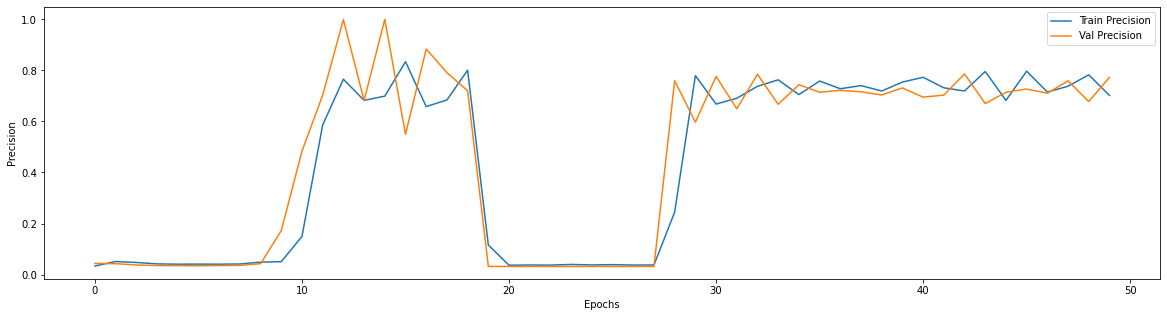

In [67]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['precision'], label='Train Precision')
plt.plot(model.history.history['val_precision'], label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

In [68]:
predict = model.predict(X_test)

In [87]:
import numpy as np
import cv2


def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:2]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

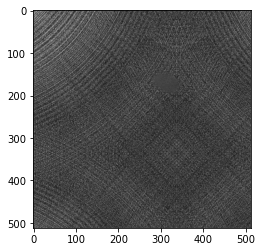

In [86]:
plt.imshow(X_test[0,:,:,0], cmap='gray')

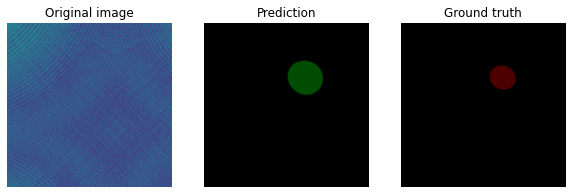

In [88]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

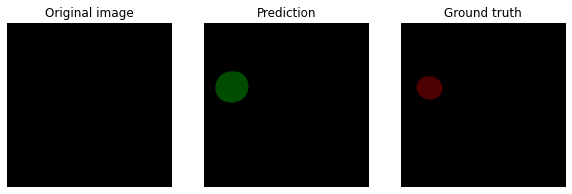

In [71]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

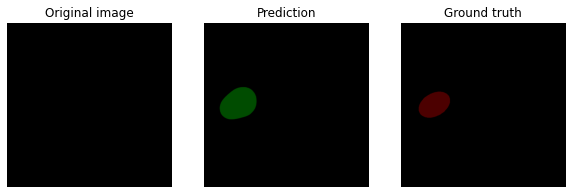

In [72]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

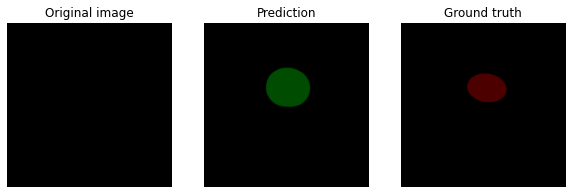

In [73]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

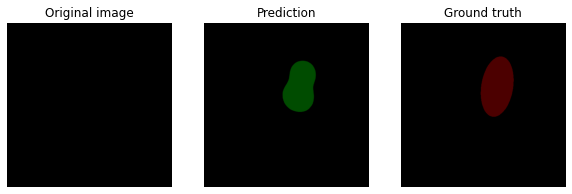

In [74]:
predict_evaluation(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

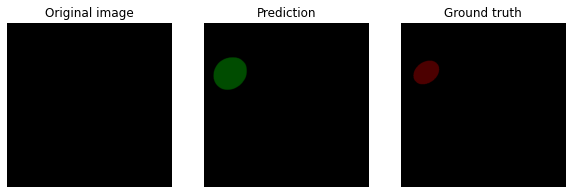

In [75]:
predict_evaluation(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

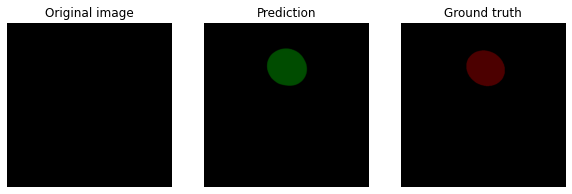

In [76]:
predict_evaluation(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

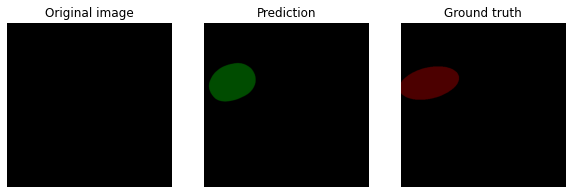

In [77]:
predict_evaluation(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

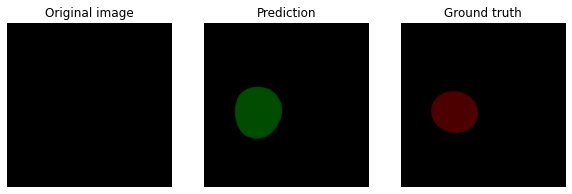

In [78]:
predict_evaluation(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

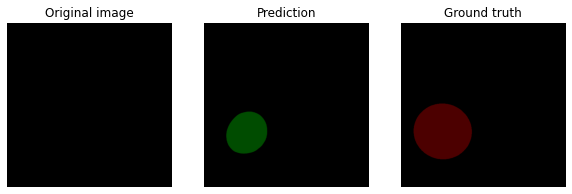

In [79]:
predict_evaluation(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])